# Factor and Empirical Covariance Matrix from NYSE TAQ

- covariance matrix shrinkage, PCA, minimum variance portfolios
- high frequency tick data, NYSE Daily TAQ

Terence Lim

In [1]:
import numpy as np
import pandas as pd
import time
import os
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from settings import settings
logdir = os.path.join(settings['images'], 'micro')  # None

# PCA of retq (midquote returns)
from settings import pickle_load
bins_df = pickle_load('tick.bins')

# remove outliers (1% tails)
date = 20191007 
key = 'retq'
df = bins_df[key].drop(columns=['Round_Lot', 'Symbol'])
df = df.loc[df['date'].eq(date) & df['decile'].lt(10)].set_index('permno')
siccd = df['siccd']
df = df.iloc[:, 5:].dropna().T
lb, ub = np.nanpercentile(df.std(axis=0), [1, 99])
X = df.loc[:, df.std(axis=0).between(lb, ub)]
siccd = siccd[X.columns]
print('samples/time(T) x features/stocks(N)', X.shape)

samples/time(T) x features/stocks(N) (77, 2319)


## Sectoring by sic or naics to FamaFrench 12-group scheme

In [2]:
from finds.database import SQL
from finds.busday import BusDay
from finds.structured import PSTAT
from finds.sectors import Sectoring
sql = SQL(**settings['sql'])
user = SQL(**settings['user'])
bd = BusDay(sql)
pstat = PSTAT(sql, bd)
sic = pstat.build_lookup('lpermno', 'sic', fillna=0)     # to lookup sic code    
naics = pstat.build_lookup('lpermno', 'naics', fillna=0) # to lookup naics code  
naics2sic = Sectoring(sql, 'sic', fillna=0)               # cross-walk           
out = Series(data=sic[X.columns], index=X.columns, name='sector')
out[out.isnull()] = naics2sic[naics[out.index[out.isnull()]]]
out[out.isnull()] = siccd[out.isnull()]
codes = Sectoring(sql, 'codes12', fillna=0)   # use FF's 12-group sectoring      
sectors = codes[out]                          # apply sic to 12-sector map       
sector_index, sector_label = pd.factorize(sectors)
sector_onehot = np.eye(len(sector_label))[sector_index]
Series(sectors).value_counts().rename('counts').to_frame().T

,Money,BusEq,Hlth,Shops,Manuf,Other,Durbl,NoDur,Utils,Enrgy,Chems,Telcm
counts,471,417,341,227,200,179,104,101,89,88,61,41


## PCA of returns covariances by SVD

In [3]:
# SVD: u S vT = x (T samples x N stocks)
x = X.sub(X.mean(axis=0), axis=1).to_numpy() # pre-process: demean by column
u, s, vT = np.linalg.svd(x, full_matrices=False)
v = vT.T
k = 10
print(np.cumsum(s[:k]**2/np.sum(np.diag(s**2))))
print('u:', u.shape, 's:', s.shape, 'vT:', vT.shape, 'v', v.shape)

# sklearn PCA: X (T samples x N features/stocks), sanity check that same results
pca = PCA()               # note: PCA first demeans input X by column mean_
y = pca.fit_transform(X)  # project X (stock returns) onto the components
print(pca.explained_variance_ratio_[:k])
print('y:', y.shape, 'x:', x.shape, 'components_:', pca.components_.shape)

# assert: s == singular_values_
print('singular values:', np.allclose(pca.singular_values_, s))

# assert: x @ v == transform(x) (aka projection on components)
print('projections:', [np.allclose((x @ v)[:,i], -y[:,i]) or
                       np.allclose((x @ v)[:,i], y[:,i]) for i in range(k)])

# assert: u @ s == transform(x)
print('projections:', [np.allclose(u[:,i]*s[i], -y[:,i]) or
                       np.allclose(u[:,i]*s[i], y[:,i]) for i in range(k)])

# assert: columns of v == rows of components_ (aka right SVD eigenvectors)
print('components:', [np.allclose(pca.components_[i,:], -v[:,i]) or
                      np.allclose(pca.components_[i,:], v[:,i])
                      for i in range(k)])

# assert: covariance matrix == loadings.T @ loadings
loadings = np.diag(pca.singular_values_) @ pca.components_
print('covariance matrix:', np.allclose(x.T @ x, loadings.T @ loadings))

[0.2078595  0.26968099 0.31115455 0.35003442 0.38570037 0.4161477
 0.44120878 0.46425862 0.48541507 0.50493292]
u: (77, 77) s: (77,) vT: (77, 2319) v (2319, 77)
[0.2078595  0.06182148 0.04147357 0.03887987 0.03566595 0.03044734
 0.02506107 0.02304984 0.02115645 0.01951785]
y: (77, 77) x: (77, 2319) components_: (77, 2319)
singular values: True
projections: [True, True, True, True, True, True, True, True, True, True]
projections: [True, True, True, True, True, True, True, True, True, True]
components: [True, True, True, True, True, True, True, True, True, True]
covariance matrix: True


## Projection on first component is similar to average "market" factor


In [4]:
t = pca.components_
DataFrame({'+ve weights': np.mean(t[:5,:] >= 0, axis=1),
           'sum': np.sum(t[:5,:], axis=1),
           'mkr corr': [np.corrcoef(x.mean(axis=1), y[:,i])[0,1]
                        for i in range(5)]},
          index=[f"PC{i+1}" for i in range(5)])

,+ve weights,sum,mkr corr
PC1,0.971539,40.530075,0.987765
PC2,0.530832,2.482964,0.033001
PC3,0.444157,-4.441082,-0.048347
PC4,0.647693,7.425087,0.078263
PC5,0.446744,-3.315855,-0.033474


## Plot components/portfolio weights distribution

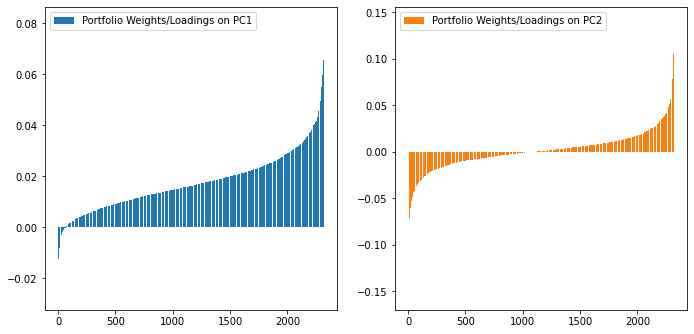

In [7]:
fig, axes = plt.subplots(1, 2, num=1, clear=True, figsize=(10,5))
for i, ax in enumerate(axes):
    ax.bar(np.arange(t.shape[1]), np.sort(t[i, :]), color=f"C{i}")
    ax.legend([f"Portfolio Weights/Loadings on PC{i+1}"])
plt.tight_layout(pad=2)
plt.savefig(os.path.join(logdir, 'weights.jpg'))
plt.show()

## Scree Plot

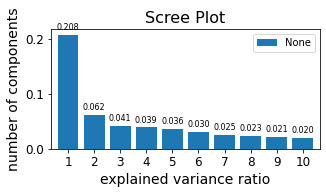

In [9]:
from finds.display import plot_bar
fig, ax = plt.subplots(1, 1, num=1, clear=True, figsize=(5,3))
k=10
plot_bar(Series(pca.explained_variance_ratio_[:k], index=np.arange(1, k+1)),
         ylabel='number of components', xlabel='explained variance ratio',
         title='Scree Plot', ax=ax,
         labels=[f"{i:.3f}" for i in pca.explained_variance_ratio_[:k]])
plt.tight_layout(pad=2)
plt.savefig(os.path.join(logdir, 'explained.jpg'))
plt.show()

## Portfolio returns/projection on PC and the market average

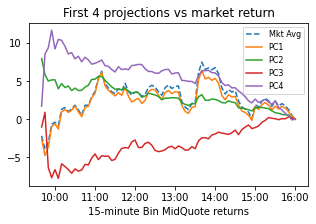

In [11]:
from matplotlib import dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()    
redirect = lambda src,tgt: src*np.sign(src.dot(tgt))  # point mkt direction
mkt = x.mean(axis=1)/np.std(x.mean(axis=1))
k = 4
fig, ax = plt.subplots(1, 1, num=1, clear=True, figsize=(5,3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.plot(X.index, np.cumsum(mkt), 'C0--')
for i in range(k):
    ax.plot(X.index,
            np.cumsum(redirect(y[:,i]/np.std(y[:,i]), mkt)), f"C{i+1}-")
ax.set_title(f"First {k} projections vs market return")
ax.legend(['Mkt Avg'] + [f'PC{i+1}' for i in range(k)], fontsize=8)
ax.set_xlabel('15-minute Bin MidQuote returns')
plt.savefig(os.path.join(logdir, 'components.jpg'))
plt.show()

## sectors exposures of (1) mkt (2) PC1 (3) PC2...

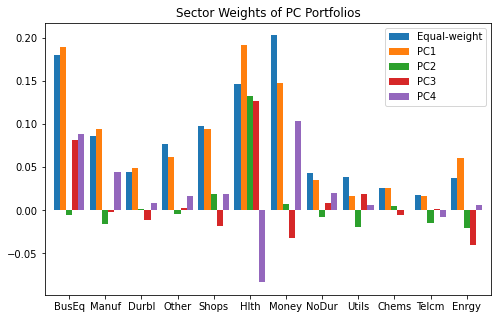

In [12]:
k = 4
p = [Series((t[i,:] @ sector_onehot)*np.sign(np.mean(t[i,:]))
            / np.sum(np.abs(t[i, :])), sector_label) for i in range(k)]
mkt = Series(np.mean(sector_onehot, axis=0), sector_label)
sec_df = pd.concat([mkt] + p, axis=1)
sec_df.columns = ['Equal-weight'] + [f"PC{i+1}" for i in range(k)]
fig, ax = plt.subplots(1,1, num=1, clear=True, figsize=(8,5))
sec_df.plot(kind='bar', ax=ax, title='Sector Weights of PC Portfolios',
            width=0.85, rot=0)
plt.savefig(os.path.join(logdir, 'sectors.jpg'))
plt.show()

## Split into train (first day) and test (second day) samples

In [13]:
from finds.busday import str2date
key = 'retq'
df = bins_df[key].drop(columns=['Symbol', 'Round_Lot'])
dates = [20191007, 20191008]

# get intradaily retq from date 0. trim 1% of stocks with outlier stdev
data = df[df['date'].eq(dates[0]) & df['decile'].lt(10)]\
       .set_index('permno').iloc[:, 5:].dropna()
data.columns = data.columns.map(
    lambda x: x.replace(**str2date(dates[0], '%Y%M%d',
                                   {'year':'%Y', 'month':'%M', 'day':'%d'})))
lb, ub = np.nanpercentile(data.std(axis=1), [1, 99])  # outlier 1% of stdev
data = data.loc[data.std(axis=1).between(lb, ub), :]  # trim stocks

# inner join next date
t = df[df['decile'].lt(10) & df['date'].eq(dates[1])]\
    .set_index('permno').iloc[:, 5:].dropna()
t.columns = t.columns.map(
    lambda x: x.replace(**str2date(dates[1], '%Y%M%d',
                                   {'year':'%Y', 'month':'%M', 'day':'%d'})))
data = data.join(t, how='inner').T
print('samples/time(T) x features/stocks(N)', data.shape)
x_train = data.iloc[:len(data)//2].to_numpy()
x_test = data.iloc[(len(data)//2):].to_numpy()

samples/time(T) x features/stocks(N) (154, 2308)


## Helper method to compute Minimum Variance Portfolio and realized volatility

In [14]:
def gmv(cov, realized=None):
    """Compute minimum variance portfolio and realized volatility"""
    w = np.linalg.inv(cov) @ np.ones((cov.shape[1], 1))
    return {'cond': np.linalg.cond(cov), 'vol': None if realized is None
            else  np.std(realized@(w/sum(w)))}

## Compare covariance risk models: fit on train split, evaluate on test split

In [15]:
from sklearn.covariance import LedoitWolf, OAS, EmpiricalCovariance
r = {}   # collect results of covariance models
cov = EmpiricalCovariance().fit(x_train).covariance_
r['Full Covariance'] = {'cond': np.linalg.cond(cov), 'vol': None}
r['Eye'] = gmv(np.identity(x_train.shape[1]), x_test)
r['Diagonal'] = gmv(np.diagflat(np.diag(cov)), x_test)
for k in [2, 5, 10, len(x_train)-2]:
    r[f"PC 1-{k}"] = gmv(PCA(k).fit(x_train).get_covariance(), x_test)
r['LW'] = gmv(LedoitWolf().fit(x_train).covariance_, x_test)
r['OAS'] = gmv(OAS().fit(x_train).covariance_, x_test)
r = DataFrame.from_dict(r, orient='index')
r.T

,Full Covariance,Eye,Diagonal,PC 1-2,PC 1-5,PC 1-10,PC 1-75,LW,OAS
cond,4.917310e+20,1.000000,761.695544,21.371971,24.396537,28.158117,145.411285,792.156702,1598.861680
vol,NaN,0.001139,0.000874,0.000699,0.000654,0.000615,0.000542,0.000520,0.000517


## Plot test period volatilities of minimum variance portfolios

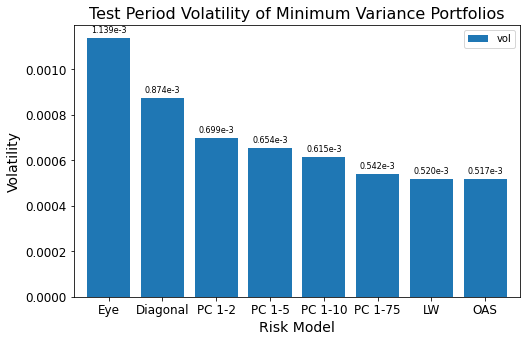

In [17]:
fig, ax = plt.subplots(1, 1, num=1, clear=True, figsize=(8,5))
plot_bar(r['vol'].dropna(), ylabel='Volatility', xlabel='Risk Model',
         title='Test Period Volatility of Minimum Variance Portfolios',
         labels=[f"{v*1000:,.3f}e-3" for v in r['vol'].dropna()], ax=ax)
plt.savefig(os.path.join(logdir, 'gmv.jpg'))
plt.show()